### Part 1: Data Preprocessing

In [1]:
import os
import re
import csv
import glob
import zipfile
import sqlite3 

import requests
import pyarrow
import pandas as pd 
import numpy as np
import seaborn as sns
import geopandas as gpd
from scipy import stats
from datetime import datetime
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from sqlalchemy import create_engine, Column, Integer, String, Float, Date, Time, DateTime
from sqlalchemy.ext.declarative import declarative_base
from sqlalchemy.orm import sessionmaker
from sqlalchemy.sql import text


## Part 1: Data Preprocessing

### Yellow Taxi dataset

#### Downloading 

In [2]:
def fetch_yellow_taxi_links(base_url):
    """
    Fetches all links to the yellow taxi data from the given base URL.

    Args:
        base_url (str): The URL to fetch the links from.

    Returns:
        list: A list of all links to the yellow taxi data.
    """
    resp = requests.get(base_url)
    resp.raise_for_status()
    soup = BeautifulSoup(resp.text, 'html.parser')
    # Select all <a> elements with href attribute containing 'yellow_tripdata'
    # and either a '.parquet' or '.zip' extension.
    links = soup.find_all('a', href=re.compile(r'^(?=.*yellow_tripdata)(?=.*(\d{4}-\d{2}\.parquet|\.zip)).*$'))
    return links


In [3]:
def fetch_taxi_data(links, start_date, end_date, retrieved_files_dir):
    """
    Downloads and extracts the yellow taxi data within the specified date range.

    Args:
        links (list): A list of links to the yellow taxi data.
        start_date (datetime.datetime): The start date of the range to download.
        end_date (datetime.datetime): The end date of the range to download.
        retrieved_files_dir (str): The directory to save the downloaded files in.
    """
    print('Checking availability of retrieved data...')
    # Create the retrieved files directory if it doesn't already exist.
    if not os.path.exists(retrieved_files_dir):
        os.makedirs(retrieved_files_dir)

    for link in links:
        url = link['href']
        file_name = url.split('/')[-1]
        date_str = file_name.split('_')[-1].split('.')[0]
        date_obj = datetime.strptime(date_str, '%Y-%m')

        if start_date <= date_obj <= end_date:
            file_path = os.path.join(retrieved_files_dir, file_name)

            if os.path.exists(file_path):
                print(f"File '{file_name}' already exists.")
            else:
                print(f"Downloading '{file_name}'...")
                response = requests.get(url)
                response.raise_for_status()

                with open(file_path, 'wb') as file:
                    file.write(response.content)

                if file_name.endswith('.zip'):
                    csv_file_name = file_name.replace('.zip', '.csv')
                    csv_file_path = os.path.join(retrieved_files_dir, csv_file_name)

                    if os.path.exists(csv_file_path):
                        print(f"File '{csv_file_name}' already exists.")
                    else:
                        print(f"Extracting '{file_name}'...")
                        with zipfile.ZipFile(file_path, 'r') as zip_file:
                            zip_file.extractall(retrieved_files_dir)

                        os.remove(file_path)

    print('Data fetching completed.')

#### Cleaning, filtering & sampling

In [5]:
def clean_and_sample_data(data: pd.DataFrame, columns_to_keep: list, columns_to_rename: dict,
                          down_threshold: float, up_threshold: float,
                          left_threshold: float, right_threshold: float, sample_size: int, year: int) -> pd.DataFrame:
    # Only keep the columns specified in columns_to_keep and create a copy of the DataFrame
    data = data[columns_to_keep].copy() 

    # Rename the columns specified in columns_to_rename
    data.rename(columns={old_name: new_name for old_name, new_name in zip(columns_to_keep, columns_to_rename)}, inplace=True)

    if year < 2011:
        # Only keep rows where Start_Lat, End_Lat, Start_Lon, and End_Lon are within specified thresholds
        data = data[(data['Start_Lat'] <= up_threshold) & (data['End_Lat'] <= up_threshold) & (data['Start_Lat'] >= down_threshold) & (
            data['End_Lat'] >= down_threshold) & (data['Start_Lon'] <= right_threshold) & (data['End_Lon'] <= right_threshold) & (
                    data['Start_Lon'] >= left_threshold) & (data['End_Lon'] >= left_threshold)]
    else:
        pass  # Do nothing if year is greater than or equal to 2011

    if data.empty:
        return data
    else:
        # Sample the specified number of rows randomly and return the resulting DataFrame
        return data.sample(sample_size, random_state=42)

In [6]:
def compile_and_clean_taxi_data() -> pd.DataFrame:
    yellow_taxi_data = pd.DataFrame()

    # Set threshold values for latitude and longitude coordinates
    down_threshold = 40.560445
    up_threshold = 40.908524
    left_threshold = -74.242330
    right_threshold = -73.717047

    # Set the number of samples to take
    sample_size = 2500

    # Define the columns to rename
    columns_to_rename = ['Pickup_Datetime', 'Dropoff_Datetime', "Trip_Distance",
                         "Start_Lon", "Start_Lat", "End_Lon", "End_Lat", "Fare_Amt", "Tip_Amt"]

    # Check if the directory for sampled files exists
    if not os.path.exists(sampled_files_dir):
        os.makedirs(sampled_files_dir)
    print('Check availability of sampled data ...')

    # Loop through the years from 2009 to 2015
    for year in range(2009, 2016):
        checked = False 
        # Loop through the months from 1 to 12
        for month in range(1, 13):
            file_name = f"sampled_data_{year}.csv"
            file_path = os.path.join(sampled_files_dir, file_name)

            # If the file exists, read in the data
            if os.path.exists(file_path):
                yellow_taxi_data = pd.read_csv(file_path)
                if not checked:
                    print(f"Sampled data from {file_name} loaded successfully!")
                checked = True
            else:
                # If the file does not exist, process the data
                print(f"Sampling {year}-{month:02d}")

                # Define the columns to keep based on the year
                if year == 2009:
                    columns_to_keep = ['Trip_Pickup_DateTime', 'Trip_Dropoff_DateTime', "Trip_Distance",
                                       "Start_Lon", "Start_Lat", "End_Lon", "End_Lat", "Fare_Amt", "Tip_Amt"] 
                elif year == 2010:
                    columns_to_keep = ['pickup_datetime', 'dropoff_datetime', "trip_distance", "pickup_longitude", "pickup_latitude",
                                       "dropoff_longitude", "dropoff_latitude", "fare_amount", "tip_amount"] 
                if year >= 2011:
                    columns_to_keep = ['tpep_pickup_datetime', 'tpep_dropoff_datetime', 'trip_distance',
                                       'Start_Lon', 'Start_Lat', 'End_Lon', 'End_Lat', 'fare_amount', 'tip_amount']

                # Read in the data for the given year and month
                data = pd.read_parquet(f"{retrieved_files_dir}/yellow_tripdata_{year}-{month:02d}.parquet")

                # If the year is 2011 or later, merge with the taxi zone data
                if year >= 2011:
                    data = data.merge(taxi_zones, left_on='PULocationID', right_on='LocationID', how='left') \
                        .rename(columns={'Lon': 'Start_Lon', 'Lat': 'Start_Lat'}) \
                        .drop(columns=['PULocationID', 'LocationID'])

                    data = data.merge(taxi_zones, left_on='DOLocationID', right_on='LocationID', how='left') \
                        .rename(columns={'Lon': 'End_Lon', 'Lat': 'End_Lat'}) \
                        .drop(columns=['DOLocationID', 'LocationID']) 

                sampled_data = clean_and_sample_data(data, columns_to_keep, columns_to_rename,
                                                     down_threshold, up_threshold, left_threshold, right_threshold,
                                                     sample_size, year)

                yellow_taxi_data = yellow_taxi_data.append(sampled_data, ignore_index=True)
            if year == 2015 and month >= 6:
                yellow_taxi_data.to_csv(file_path, index=False)
                break
        if not os.path.exists(file_path):
            yellow_taxi_data.to_csv(file_path, index=False)
            print(f"Sampled data saved as {file_path}") 

            
    yellow_taxi_data.to_csv("sampled_taxi_data_2009_2015.csv", index=False)
    print(f"Sampled Yellow Taxi dataset saved as {file_path}") 
    return yellow_taxi_data


In [7]:
def load_taxi_zones():
    """
    Load and preprocess the NYC Taxi Zones shapefile into a GeoDataFrame.
    
    Returns:
        geopandas.GeoDataFrame: The GeoDataFrame with processed Taxi Zone data.
    """
    # load the Taxi Zones shapefile into a GeoDataFrame
    zones = gpd.read_file('taxi_zone_data/taxi_zones.shp')
    
    # convert the projection of the GeoDataFrame to EPSG 2263 (US feet) to match the projection of the taxi data
    zones = zones.to_crs(epsg=2263)
    
    # add columns for the longitude and latitude of the centroid of each zone
    zones['Lon'] = zones.centroid.x
    zones['Lat'] = zones.centroid.y
    
    # drop columns that won't be used in the analysis
    zones = zones.drop(columns=['OBJECTID', 'Shape_Leng', 'Shape_Area', 'zone', 'borough', 'geometry'])
    
    # return the processed GeoDataFrame
    return zones

In [8]:
# Define the main URL to fetch the yellow taxi data links from.
main_url = 'https://www1.nyc.gov/site/tlc/about/tlc-trip-record-data.page'


In [9]:
# Define the start and end dates for the data range to download.
start_date = datetime(2009, 1, 1)
end_date = datetime(2015, 6, 30)

In [10]:
# Define the directory to save the downloaded files in.
retrieved_files_dir = 'monthly_data'
# Define the directory to save the sampled files in.
sampled_files_dir = 'sampled_data'

In [11]:
# Download and extract the yellow taxi data within the specified date range.
yellow_taxi_links = fetch_yellow_taxi_links(main_url)
fetch_taxi_data(yellow_taxi_links, start_date, end_date, retrieved_files_dir)

Checking availability of retrieved data...
File 'yellow_tripdata_2015-01.parquet' already exists.
File 'yellow_tripdata_2015-02.parquet' already exists.
File 'yellow_tripdata_2015-03.parquet' already exists.
File 'yellow_tripdata_2015-04.parquet' already exists.
File 'yellow_tripdata_2015-05.parquet' already exists.
File 'yellow_tripdata_2015-06.parquet' already exists.
File 'yellow_tripdata_2014-01.parquet' already exists.
File 'yellow_tripdata_2014-02.parquet' already exists.
File 'yellow_tripdata_2014-03.parquet' already exists.
File 'yellow_tripdata_2014-04.parquet' already exists.
File 'yellow_tripdata_2014-05.parquet' already exists.
File 'yellow_tripdata_2014-06.parquet' already exists.
File 'yellow_tripdata_2014-07.parquet' already exists.
File 'yellow_tripdata_2014-08.parquet' already exists.
File 'yellow_tripdata_2014-09.parquet' already exists.
File 'yellow_tripdata_2014-10.parquet' already exists.
File 'yellow_tripdata_2014-11.parquet' already exists.
File 'yellow_tripdata_

In [12]:
# Load the taxi zone lookup data.
taxi_zones = load_taxi_zones()

In [13]:
# Compile and clean the downloaded taxi data, and save the sampled data to disk.
compiled_taxi_data = compile_and_clean_taxi_data()

Check availability of sampled data ...
Sampled data from sampled_data_2009.csv loaded successfully!
Sampled data from sampled_data_2010.csv loaded successfully!
Sampled data from sampled_data_2011.csv loaded successfully!
Sampled data from sampled_data_2012.csv loaded successfully!
Sampled data from sampled_data_2013.csv loaded successfully!
Sampled data from sampled_data_2014.csv loaded successfully!
Sampling 2015-01
Sampling 2015-02
Sampling 2015-03
Sampling 2015-04
Sampling 2015-05
Sampling 2015-06
Sampled Yellow Taxi dataset saved as sampled_data/sampled_data_2015.csv


In [14]:
compiled_taxi_data.head()

,Pickup_Datetime,Dropoff_Datetime,Trip_Distance,Start_Lon,Start_Lat,End_Lon,End_Lat,Fare_Amt,Tip_Amt
0,2009-01-04 07:53:32,2009-01-04 08:10:30,11.0,-73.862767,40.769043,-73.992901,40.697823,25.3,0.00
1,2009-01-25 03:29:10,2009-01-25 03:35:52,2.4,-73.977883,40.745888,-73.956754,40.772334,8.2,1.23
2,2009-01-31 20:34:17,2009-01-31 20:47:42,0.5,-73.987889,40.749865,-73.987705,40.755688,8.2,0.00
3,2009-01-21 15:05:16,2009-01-21 15:21:11,1.9,-73.990142,40.731772,-74.008403,40.725475,9.7,0.00
4,2009-01-26 19:59:38,2009-01-26 20:14:16,3.1,-73.970618,40.755777,-74.004455,40.742319,11.9,0.00


#### distance calculation

In [15]:
def haversine_distance(lat1: float, lon1: float, lat2: float, lon2: float) -> float:
    # Haversine formula for calculating the distance between two points on Earth
    R = 6371  # Earth's radius in kilometers
    lat1, lon1, lat2, lon2 = map(np.radians, [lat1, lon1, lat2, lon2])
    dlat = lat2 - lat1
    dlon = lon2 - lon1
    a = np.sin(dlat / 2) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    return R * c
 

#### Adding distance feature

In [16]:
def add_distance_features(data: pd.DataFrame) -> pd.DataFrame:
    """
    Add columns to a Pandas dataframe with distance-related features calculated using the haversine distance formula.
    
    Args:
        data (pd.DataFrame): The dataframe to which distance-related features will be added.
        
    Returns:
        pd.DataFrame: The dataframe with new columns for distance-related features.
    """
    # apply the haversine_distance function to each row of the dataframe to calculate the distance between the start and end coordinates
    data['Real_Distance'] = data.apply(lambda row: haversine_distance(row["Start_Lat"], row["Start_Lon"], row["End_Lat"], row["End_Lon"]), axis=1)
    
    # return the dataframe with the new columns added
    return data

In [17]:
# load the CSV file into a Pandas dataframe
yellow_taxi_dataset = pd.read_csv("sampled_taxi_data_2009_2015.csv")

In [18]:
# apply the 'add_distance_features' function to the dataframe to add new columns with distance-related features
yellow_taxi_dataset = add_distance_features(yellow_taxi_dataset)

In [19]:
yellow_taxi_dataset.head()

,Pickup_Datetime,Dropoff_Datetime,Trip_Distance,Start_Lon,Start_Lat,End_Lon,End_Lat,Fare_Amt,Tip_Amt,Real_Distance
0,2009-01-04 07:53:32,2009-01-04 08:10:30,11.0,-73.862767,40.769043,-73.992901,40.697823,25.3,0.00,13.525673
1,2009-01-25 03:29:10,2009-01-25 03:35:52,2.4,-73.977883,40.745888,-73.956754,40.772334,8.2,1.23,3.437221
2,2009-01-31 20:34:17,2009-01-31 20:47:42,0.5,-73.987889,40.749865,-73.987705,40.755688,8.2,0.00,0.647674
3,2009-01-21 15:05:16,2009-01-21 15:21:11,1.9,-73.990142,40.731772,-74.008403,40.725475,9.7,0.00,1.690572
4,2009-01-26 19:59:38,2009-01-26 20:14:16,3.1,-73.970618,40.755777,-74.004455,40.742319,11.9,0.00,3.219327


### Uber dataset

In [20]:
uber_data = pd.read_csv("uber_rides_sample.csv") 

In [21]:
def load_and_clean_uber_data(csv_file) -> pd.DataFrame:
    csv_file = csv_file.dropna()
    
    # Set the latitude and longitude
    csv_file = csv_file[(csv_file['pickup_latitude'] >= 40.560445) &
                        (csv_file['pickup_latitude'] <= 40.908524) &
                        (csv_file['pickup_longitude'] >= -74.242330) &
                        (csv_file['pickup_longitude'] <= -73.717047) &
                        (csv_file['dropoff_latitude'] >= 40.560445) &
                        (csv_file['dropoff_latitude'] <= 40.908524) &
                        (csv_file['dropoff_longitude'] >= -74.242330) &
                        (csv_file['dropoff_longitude'] <= -73.717047)]
    
    # Convert pickup_datetime column to datetime format
    csv_file.loc[:, 'pickup_datetime'] = pd.to_datetime(csv_file['pickup_datetime'], format='%Y-%m-%d %H:%M:%S UTC')

    # Create new columns for pickup date and time, as well as year, month, day, and hour
    csv_file.loc[:, 'Pickup_Date'] = csv_file['pickup_datetime'].dt.date
    csv_file.loc[:, 'Pickup_Time'] = csv_file['pickup_datetime'].dt.time
    csv_file.loc[:, 'Year'] = csv_file['pickup_datetime'].dt.year
    csv_file.loc[:, 'Month'] = csv_file['pickup_datetime'].dt.month
    csv_file.loc[:, 'Day'] = csv_file['pickup_datetime'].dt.day
    csv_file.loc[:, 'Hour'] = csv_file['pickup_datetime'].dt.hour
    
    # Convert pickup datetime to datetime object
    csv_file.loc[:, 'Pickup'] = pd.to_datetime(csv_file['pickup_datetime'])
    
    # Extract day of the week from pickup datetime
    csv_file.loc[:, 'DayofWeek'] = csv_file['Pickup'].dt.dayofweek
    
    # Combine latitude and longitude columns into tuples
    csv_file['Start_point'] = list(zip(csv_file['pickup_latitude'], csv_file['pickup_longitude']))
    csv_file['End_point'] = list(zip(csv_file['dropoff_latitude'], csv_file['dropoff_longitude']))
    
    csv_file = csv_file.drop(columns=['key', 'Unnamed: 0', 'passenger_count', 'Pickup_Time', 'pickup_datetime'])\
                 .rename(columns={'pickup_longitude': 'Start_Lon',
                                  'pickup_latitude': 'Start_Lat',
                                  'dropoff_longitude': 'End_Lon',
                                  'dropoff_latitude': 'End_Lat',
                                  'fare_amount': 'Fare_Amt',
                                  'Pickup_Date': 'Date'})
    
    
    return csv_file

In [22]:
def get_uber_data() -> pd.DataFrame: 
    # Load and clean the Uber dataset, and add distance features to the dataset
    uber_dataframe = load_and_clean_uber_data(uber_data)
    add_distance_features(uber_dataframe)

    # Remove unnecessary columns from the dataset, and convert the 'Pickup' column to datetime format
    uber_dataframe.drop(columns=["Start_point", "End_point"], inplace=True)
    uber_dataframe["Pickup"] = pd.to_datetime(uber_dataframe["Pickup"])

    # Extract date from the 'Pickup' column and create a new column 'Pickup_Date'
    uber_dataframe['Pickup_Date'] = uber_dataframe['Pickup'].dt.date

    # Convert the 'Hour' and 'DayofWeek' columns to integers, and rename the 'Real_Distance' column to 'Trip_distance'
    uber_dataframe['Hour'] = uber_dataframe['Hour'].astype(int)
    uber_dataframe['DayofWeek'] = uber_dataframe['DayofWeek'].astype(int)
    uber_dataframe.rename(columns={'Real_Distance': 'Trip_distance'}, inplace=True)

    return uber_dataframe

In [23]:
uber_dataset = get_uber_data()

In [24]:
uber_dataset.head()

,Fare_Amt,Start_Lon,Start_Lat,End_Lon,End_Lat,Date,Year,Month,Day,Hour,Pickup,DayofWeek,Trip_distance,Pickup_Date
0,7.5,-73.999817,40.738354,-73.999512,40.723217,2015-05-07,2015,5,7,19,2015-05-07 19:52:06,3,1.683323,2015-05-07
1,7.7,-73.994355,40.728225,-73.994710,40.750325,2009-07-17,2009,7,17,20,2009-07-17 20:04:56,4,2.457590,2009-07-17
2,12.9,-74.005043,40.740770,-73.962565,40.772647,2009-08-24,2009,8,24,21,2009-08-24 21:45:00,0,5.036377,2009-08-24
3,5.3,-73.976124,40.790844,-73.965316,40.803349,2009-06-26,2009,6,26,8,2009-06-26 08:22:21,4,1.661683,2009-06-26
4,16.0,-73.925023,40.744085,-73.973082,40.761247,2014-08-28,2014,8,28,17,2014-08-28 17:47:00,3,4.475450,2014-08-28


### Whether Data

In [34]:
import os
import pandas as pd


# Define a list of column names for the weather data
WEATHER_COLUMNS = [
    'DATE',
    'LATITUDE',
    'LONGITUDE',
    
    'Sunrise',
    'Sunset',
    
    'DailyPeakWindSpeed',
    'DailyPrecipitation',
    'DailySustainedWindSpeed',
    'DailyAverageWindSpeed',
    
    'HourlyWindSpeed',
    'HourlyPrecipitation',   
] 


# Define a function to get all CSV files in a directory
def get_csv_files(directory: str) -> list:
    return [os.path.join(directory, file) for file in os.listdir(directory) if file.endswith('.csv')]


# Define a function to merge multiple CSV files into a single DataFrame
def merge_csv_files(files: list, columns: list) -> pd.DataFrame:
    return pd.concat([pd.read_csv(file, usecols=columns) for file in files])


# Define a function to split the 'DATE' column into separate 'Date' and 'Time' columns
def split_datetime_column(weather_data: pd.DataFrame) -> None:
    datetime_data = pd.to_datetime(weather_data['DATE'])
    weather_data['Date'] = datetime_data.dt.date.astype(str)
    weather_data['Time'] = datetime_data.dt.time.astype(str)
    weather_data.drop(columns=['DATE'], inplace=True)


# Define a function to save the merged weather data to a CSV file
def save_weather_data(weather_data: pd.DataFrame, output_file: str) -> None:
    weather_data.to_csv(output_file, index=False)
    weather_data.dropna(inplace=True)


# Define a function to merge all weather files in a directory, split the 'DATE' column, and save the result to a CSV file
def merge_weather_files() -> None:
    files = get_csv_files('weather_data')
    weather_data = merge_csv_files(files, WEATHER_COLUMNS)
    split_datetime_column(weather_data)
    save_weather_data(weather_data, 'WeatherData.csv')



In [35]:
def get_hourly_weather_data(csv_file) -> pd.DataFrame:
    # Select rows with Time column containing "51:00"
    weather_hourly = csv_file[csv_file['Time'].str.contains("51:00")]

    # Extract HourlyWindSpeed, HourlyPrecipitation, Time, and Date columns into a new dataframe
    weather_hourly = weather_hourly.loc[:, ["HourlyWindSpeed", "HourlyPrecipitation", "Time", "Date"]]

    # Replace missing and "T" values in HourlyPrecipitation column with 0.005
    weather_hourly["HourlyPrecipitation"] = weather_hourly["HourlyPrecipitation"].fillna(0).str.replace("T", "0.005")

    # Replace missing, "T", and "nan" values in HourlyWindSpeed column with 0, and convert to numeric data type
    weather_hourly["HourlyWindSpeed"] = pd.to_numeric(weather_hourly["HourlyWindSpeed"].fillna(0).replace(["T", "nan"], 0.005).replace("nan", 0))

    # Combine Date and Time columns to create a new datetime column
    weather_hourly['Record_Time'] = pd.to_datetime(weather_hourly['Date'] + ' ' + weather_hourly['Time'])

    # Extract Year, Month, Day, and Hour from the datetime column
    weather_hourly['Year'] = weather_hourly['Record_Time'].dt.year
    weather_hourly['Month'] = weather_hourly['Record_Time'].dt.month
    weather_hourly['Day'] = weather_hourly['Record_Time'].dt.day
    weather_hourly['Hour'] = weather_hourly['Record_Time'].dt.hour

    # Drop Unnecessary Columns
    weather_hourly.drop(columns=['Time'], inplace=True)
    weather_hourly.dropna(inplace=True)
    return weather_hourly


def get_daily_weather_data(csv_file) -> pd.DataFrame:
    # Select relevant columns and replace T with 0.005
    weather_daily = csv_file.loc[:, ['DailyPrecipitation', 'DailySustainedWindSpeed', 'DailyPeakWindSpeed', 'DailyAverageWindSpeed', 'Time', 'Date']]
    weather_daily['DailyPrecipitation'] = weather_daily['DailyPrecipitation'].replace('T', 0.005)

    # Drop rows with any missing values
    weather_daily.dropna(inplace=True)

    # Combine date and time columns to create 'Record_Time'
    weather_daily['Record_Time'] = pd.to_datetime(weather_daily['Date'] + ' ' + weather_daily['Time'])
    
    # Extract year, month, day, and hour from Record_Time column
    weather_daily['Year'], weather_daily['Month'], weather_daily['Day'], weather_daily['Hour'] = \
        weather_daily['Record_Time'].dt.year, weather_daily['Record_Time'].dt.month, \
        weather_daily['Record_Time'].dt.day, weather_daily['Record_Time'].dt.hour

    # Drop the Time column
    weather_daily.drop(columns=['Time'], inplace=True)
    weather_daily.dropna(inplace=True)
    return weather_daily





def get_daily_sun_data(csv_file) -> pd.DataFrame:
    
    weather_sun = csv_file[['Sunrise', 'Sunset', 'Date']].dropna().reset_index(drop=True)

    
    weather_sun[['Sunrise', 'Sunset']] = weather_sun[['Sunrise', 'Sunset']].apply(
        lambda x: pd.to_datetime(x, format='%H%M').dt.time)



    # Concatenate Date and Sunrise columns to create a new column Sunrise_DateTime
    weather_sun['Sunrise_DateTime'] = pd.to_datetime(weather_sun['Date'] + ' ' + weather_sun['Sunrise'].astype(str))

    # Convert Sunrise_DateTime column to Sunrise column and drop Sunrise_DateTime column
    weather_sun['Sunrise'] = weather_sun['Sunrise_DateTime']
    weather_sun.drop(columns=['Sunrise_DateTime'], inplace=True)

    # Concatenate Date and Sunset columns to create a new column Sunset_DateTime
    weather_sun['Sunset_DateTime'] = pd.to_datetime(weather_sun['Date'] + ' ' + weather_sun['Sunset'].astype(str))

    # Convert Sunset_DateTime column to Sunset column and drop Sunset_DateTime column
    weather_sun['Sunset'] = weather_sun['Sunset_DateTime']
    weather_sun.drop(columns=['Sunset_DateTime'], inplace=True)
    weather_sun.dropna(inplace=True)

    return weather_sun

In [36]:
merge_weather_files()
weather_dataset = pd.read_csv('WeatherData.csv')

In [37]:
# Call the 'get_hourly_weather_data' function to get hourly weather data
hourly_weather_dataset = get_hourly_weather_data(weather_dataset)
hourly_weather_dataset.head()

,HourlyWindSpeed,HourlyPrecipitation,Date,Record_Time,Year,Month,Day,Hour
24,3.0,0.01,2012-01-01,2012-01-01 18:51:00,2012,1,1,18
25,7.0,0.005,2012-01-01,2012-01-01 19:51:00,2012,1,1,19
26,9.0,0.04,2012-01-01,2012-01-01 20:51:00,2012,1,1,20
27,11.0,0.005,2012-01-01,2012-01-01 21:51:00,2012,1,1,21
269,11.0,0.005,2012-01-11,2012-01-11 21:51:00,2012,1,11,21


In [38]:
# Call the 'get_daily_weather_data' function to get daily weather data
daily_weather_dataset = get_daily_weather_data(weather_dataset)
daily_weather_dataset.head()

,DailyPrecipitation,DailySustainedWindSpeed,DailyPeakWindSpeed,DailyAverageWindSpeed,Date,Record_Time,Year,Month,Day,Hour
5796,0.00,10.0,15.0,3.8,2012-07-31,2012-07-31 23:59:00,2012,7,31,23
5850,0.64,9.0,15.0,2.3,2012-08-01,2012-08-01 23:59:00,2012,8,1,23
5876,0.00,12.0,19.0,2.7,2012-08-02,2012-08-02 23:59:00,2012,8,2,23
5902,0.00,9.0,17.0,3.5,2012-08-03,2012-08-03 23:59:00,2012,8,3,23
5935,0.00,12.0,21.0,3.1,2012-08-04,2012-08-04 23:59:00,2012,8,4,23


In [39]:
# Call the 'get_daily_sun_data' function to get daily sunrise and sunset times
daily_sun_dataset = get_daily_sun_data(weather_dataset)
daily_sun_dataset.head()

,Sunrise,Sunset,Date
0,2012-01-01 07:20:00,2012-01-01 16:39:00,2012-01-01
1,2012-01-10 07:20:00,2012-01-10 16:48:00,2012-01-10
2,2012-01-11 07:20:00,2012-01-11 16:49:00,2012-01-11
3,2012-01-12 07:19:00,2012-01-12 16:50:00,2012-01-12
4,2012-01-13 07:19:00,2012-01-13 16:51:00,2012-01-13


## Part 2: Storing Data

### create a SQLite database:

In [40]:
SCHEMA_FILE = "schema.sql"
QUERY_DIRECTORY = "queries"

In [41]:
conn = sqlite3.connect("project.db")

# Write data to the tables
yellow_taxi_dataset.to_sql("yellow_taxi_database", conn, if_exists="replace", index=False)
uber_dataset.to_sql("uber_database", conn, if_exists="replace", index=False)
hourly_weather_dataset.to_sql("hourly_weather_database", conn, if_exists="replace", index=False)
daily_weather_dataset.to_sql("daily_weather_database", conn, if_exists="replace", index=False)

# Close the connection
conn.close()

In [42]:
### create table
DAILY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS daily_weather_database
(
    id INTEGER PRIMARY KEY,
    DailyPrecipitation FLOAT,
    DailySustainedWindSpeed FLOAT,
    DailyPeakWindSpeed FLOAT,
    DailyAverageWindSpeed FLOAT,
    Date TIMESTAMP,
    Record_Time TIMESTAMP,
    Year INTEGER,
    Month INTEGER,
    Day INTEGER,
    Hour INTEGER
);
"""

HOURLY_WEATHER_SCHEMA = """
CREATE TABLE IF NOT EXISTS hourly_weather_database
(
    id INTEGER PRIMARY KEY,
    HourlyWindSpeed FLOAT,
    HourlyPrecipitation FLOAT,
    Date TIMESTAMP,
    Record_Time TIMESTAMP,
    Year INTEGER,
    Month INTEGER,
    Day INTEGER,
    Hour INTEGER
);
"""

TAXI_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS yellow_taxi_database
(
    id INTEGER PRIMARY KEY,
    Date TIMESTAMP,
    Pickup TIMESTAMP,
    Pickup_Time TIMESTAMP,
    Trip_Distance FLOAT,
    Start_Lon FLOAT,
    Start_Lat FLOAT,
    End_Lon FLOAT,
    End_Lat FLOAT,
    Fare_Amt FLOAT,
    Tip_Amt FLOAT,
    Year INTEGER,
    Month INTEGER,
    Day INTEGER,
    Time INTEGER,
    DayofWeek INTEGER
);
"""

UBER_TRIPS_SCHEMA = """
CREATE TABLE IF NOT EXISTS uber_database
(
    id INTEGER PRIMARY KEY,
    Fare_Amt FLOAT,
    Start_Lon FLOAT,
    Start_Lat FLOAT,
    End_Lon FLOAT,
    End_Lat FLOAT,
    Date TIMESTAMP,
    Year INTEGER,
    Month INTEGER,
    Day INTEGER,
    Hour INTEGER,
    Pickup TIMESTAMP,
    DayofWeek INTEGER,
    Trip_Distance FLOAT,
    Pickup_Date TIMESTAMP
);
"""

In [43]:
# Create the required schema.sql file
with open(SCHEMA_FILE, "w") as f:
    f.write(HOURLY_WEATHER_SCHEMA)
    f.write(DAILY_WEATHER_SCHEMA)
    f.write(TAXI_TRIPS_SCHEMA)
    f.write(UBER_TRIPS_SCHEMA)

# Connect to the SQLite database
conn = sqlite3.connect("project.db")

In [44]:
# Create the tables with the schema files
with conn:
    conn.execute(HOURLY_WEATHER_SCHEMA)
    conn.execute(DAILY_WEATHER_SCHEMA)
    conn.execute(TAXI_TRIPS_SCHEMA)
    conn.execute(UBER_TRIPS_SCHEMA)

# Close the connection
conn.close()

## Part 3: Understanding the Data

In [157]:
# Connect to the SQLite database
conn = sqlite3.connect("project.db")

In [187]:
# Query 1
query1 = """
    SELECT strftime('%Y-%m-%d', Pickup_Datetime) as Date, strftime('%H', Pickup_Datetime) as Hour, COUNT(*) as Trips
    FROM yellow_taxi_database
    WHERE strftime('%Y-%m-%d', Pickup_Datetime) BETWEEN '2009-01-01' AND '2015-06-30'
    GROUP BY Date, Hour
    ORDER BY Trips DESC;
    """
result1 = pd.read_sql_query(query1, conn)
result1.to_sql('result1', conn, index=False, if_exists='replace')
print(result1)


             Date Hour  Trips
0      2013-08-22   20     17
1      2015-04-19   14     16
2      2009-02-14   23     15
3      2010-02-13   20     15
4      2013-05-04   19     15
...           ...  ...    ...
50796  2015-06-28   18      1
50797  2015-06-29   01      1
50798  2015-06-29   03      1
50799  2015-06-30   05      1
50800  2015-06-30   12      1

[50801 rows x 3 columns]


In [177]:
# Define the SQL query
query2 = """
    SELECT Pickup_Date as Weekday, COUNT(*) as Trips
    FROM uber_database
    WHERE Pickup_Date BETWEEN '2009-01-01' AND '2015-06-30'
    GROUP BY Weekday
    ORDER BY Trips DESC;
"""

# Execute the query and store the results in a Pandas dataframe
result2 = pd.read_sql_query(query2, conn)
result2.to_sql('result2', conn, index=False, if_exists='replace')

# Print the dataframe
print(result2)

         Weekday  Trips
0     2009-12-11    127
1     2011-04-27    125
2     2009-10-23    123
3     2011-06-08    123
4     2012-03-23    122
...          ...    ...
2367  2014-12-25     25
2368  2015-01-27     22
2369  2012-10-29     21
2370  2010-12-27     13
2371  2011-08-28      7

[2372 rows x 2 columns]


In [171]:
# Query 3
query3 = '''
    WITH combined_trips AS (
        SELECT Trip_Distance, 
               CASE
                   WHEN Pickup_Datetime IS NOT NULL THEN strftime('%Y-%m-%d', Pickup_Datetime)
                   ELSE strftime('%Y-%m-%d', Pickup_Date)
               END as Trip_Date
        FROM (
            SELECT Trip_Distance, Pickup_Datetime, NULL as Pickup_Date 
            FROM yellow_taxi_database 
            WHERE Pickup_Datetime BETWEEN '2013-07-01' AND '2013-07-31'
            UNION ALL
            SELECT Trip_Distance, NULL as Pickup_Datetime, Pickup_Date 
            FROM uber_database 
            WHERE Pickup_Date BETWEEN '2013-07-01' AND '2013-07-31'
        )
    ),
    ordered_trips AS (
        SELECT Trip_Distance, 
               ROW_NUMBER() OVER (ORDER BY Trip_Distance) AS row_num,
               (SELECT COUNT(*) FROM combined_trips) AS total_count
        FROM combined_trips
    )
    SELECT Trip_Distance
    FROM ordered_trips
    WHERE row_num = ROUND(total_count * 0.95);
    '''

result3 = pd.read_sql_query(query3, conn)
result3.to_sql('result3', conn, index=False, if_exists='replace')

print(result3)

   Trip_Distance
0      10.216086


In [161]:

# What were the top 10 days with the highest number of hired rides for 2009, and what was the average distance for each day?

# Query 4
query4 = """
    WITH Combined_Trips AS (
        SELECT strftime('%Y-%m-%d', Pickup_Datetime) as Date, Trip_Distance
        FROM yellow_taxi_database
        WHERE strftime('%Y', Date) = '2009'
        UNION ALL
        SELECT strftime('%Y-%m-%d', Pickup_Date) as Date, Trip_Distance
        FROM uber
        WHERE strftime('%Y', Date) = '2009'
    )
    SELECT Date, COUNT(*) as Rides, AVG(Trip_Distance) as Avg_Distance
    FROM Combined_Trips
    GROUP BY Date
    ORDER BY Rides DESC
    LIMIT 10;
    """
result4 = pd.read_sql_query(query4, conn)

result4.to_sql('result4', conn, index=False, if_exists='replace')
print(result4)


         Date  Rides  Avg_Distance
0  2009-12-11    234      2.789095
1  2009-01-31    225      2.389727
2  2009-02-19    213      2.867974
3  2009-06-19    211      2.896776
4  2009-12-04    210      2.507848
5  2009-02-18    209      2.980824
6  2009-08-14    209      2.978543
7  2009-05-08    206      2.916524
8  2009-01-27    204      2.478543
9  2009-04-18    204      3.161798


In [169]:
# Query 5
query5 = """
    WITH 
        yellow_trips AS (
            SELECT 
                strftime('%Y-%m-%d', Pickup_Datetime) as Date, 
                COUNT(*) as Trips
            FROM yellow_taxi_database
            WHERE Date BETWEEN '2014-01-01' AND '2014-12-31'
            GROUP BY Date
        ),
        uber_trips AS (
            SELECT 
                strftime('%Y-%m-%d', Pickup_Date) as Date, 
                COUNT(*) as Trips
            FROM uber_database
            WHERE Date BETWEEN '2014-01-01' AND '2014-12-31'
            GROUP BY Date
        ),
        daily_stats AS (
            SELECT 
                Date, 
                AVG(DailyAverageWindSpeed) as Avg_Wind_Speed
            FROM daily_weather
            WHERE Date BETWEEN '2014-01-01' AND '2014-12-31'
            GROUP BY Date
        )
    SELECT 
        daily_stats.Date, 
        daily_stats.Avg_Wind_Speed, 
        COALESCE(yellow_trips.Trips, 0) + COALESCE(uber_trips.Trips, 0) AS Hired_Trips
    FROM 
        daily_stats 
        LEFT JOIN yellow_trips ON daily_stats.Date = yellow_trips.Date 
        LEFT JOIN uber_trips ON daily_stats.Date = uber_trips.Date
    ORDER BY 
        daily_stats.Avg_Wind_Speed DESC
    LIMIT 
        10;
    """
result5 = pd.read_sql_query(query5, conn)

result5.to_sql('result5', conn, index=False, if_exists='replace')
print(result5)

         Date  Avg_Wind_Speed  Hired_Trips
0  2014-03-13            14.1          198
1  2014-01-07            13.1          145
2  2014-02-13            12.6          123
3  2014-01-02            12.2          123
4  2014-03-26            11.9          189
5  2014-12-07            11.8          175
6  2014-12-08            11.5          158
7  2014-03-29            10.8          184
8  2014-11-02            10.8          170
9  2014-01-03            10.4           99


In [163]:
# Query 6
query6 = '''
WITH hourly_trips AS (
    SELECT COUNT(*) AS num_rides, strftime('%Y-%m-%d %H', Pickup_Datetime) AS hour
    FROM (
        SELECT Pickup_Datetime FROM yellow_taxi_database WHERE strftime('%Y-%m-%d %H', Pickup_Datetime) BETWEEN '2012-10-22 00' AND '2012-11-06 23'
        UNION ALL
        SELECT Pickup_Date FROM uber_database WHERE strftime('%Y-%m-%d %H', Pickup_Date) BETWEEN '2012-10-22 00' AND '2012-11-06 23'
    ) all_trips
    GROUP BY hour
),
hourly_weather_data AS (
    SELECT strftime('%Y-%m-%d %H', Record_Time) AS hour, AVG(HourlyWindSpeed) AS avg_wind_speed, SUM(HourlyPrecipitation) AS total_precipitation
    FROM hourly_weather_database
    WHERE strftime('%Y-%m-%d %H', Record_Time) BETWEEN '2012-10-22 00' AND '2012-11-06 23'
    GROUP BY hour
),
all_hours AS (
    SELECT strftime('%Y-%m-%d %H', Record_Time) AS hour
    FROM hourly_weather_database
    WHERE strftime('%Y-%m-%d %H', Record_Time) BETWEEN '2012-10-22 00' AND '2012-11-06 23'
)
SELECT all_hours.hour, COALESCE(hourly_trips.num_rides, 0) AS num_rides, COALESCE(hourly_weather_data.total_precipitation, 0) AS total_precipitation, COALESCE(hourly_weather_data.avg_wind_speed, 0) AS avg_wind_speed
FROM all_hours
LEFT JOIN hourly_trips ON all_hours.hour = hourly_trips.hour
LEFT JOIN hourly_weather_data ON all_hours.hour = hourly_weather_data.hour
ORDER BY all_hours.hour;
'''


result6 = pd.read_sql_query(query6, conn)
result6.to_sql('result2', conn, index=False, if_exists='replace')

print(result6)


              hour  num_rides  total_precipitation  avg_wind_speed
0    2012-10-22 00         76                0.025        6.200000
1    2012-10-22 01          0                0.015        5.266667
2    2012-10-22 02          0                0.035        5.266667
3    2012-10-22 03          0                0.040        6.800000
4    2012-10-22 04          1                0.005        6.000000
..             ...        ...                  ...             ...
361  2012-11-06 19          7                0.000        0.000000
362  2012-11-06 20          2                0.000        0.000000
363  2012-11-06 21          3                0.000        0.000000
364  2012-11-06 22          5                0.000        0.000000
365  2012-11-06 23          3                0.000        0.000000

[366 rows x 4 columns]


In [164]:
#### part 4

In [165]:
# Set the seaborn style
sns.set_style("whitegrid")


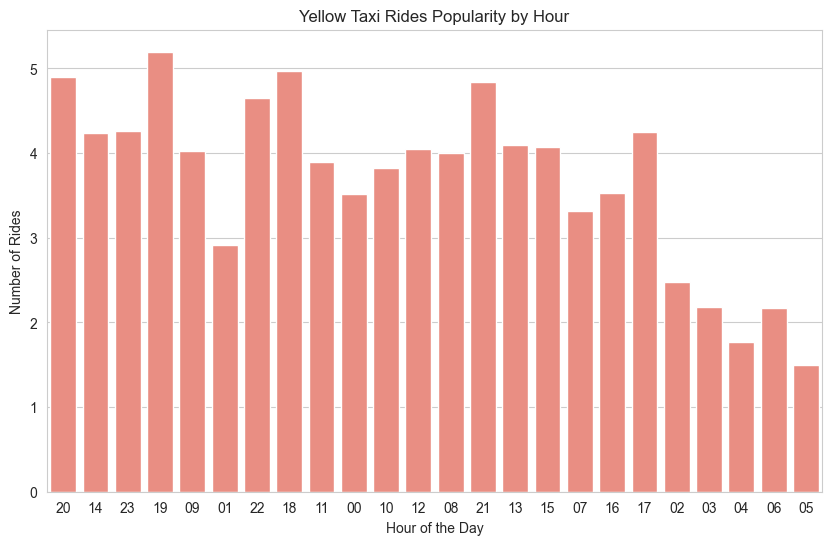

In [188]:
# Define a function for the first visualization from Query 1 in Part 3.
def visualize_query1():
    conn = sqlite3.connect("project.db")
    query1 = "SELECT * FROM result1;"
    df = pd.read_sql_query(query1, conn)
    
    plt.figure(figsize=(10, 6))
    sns.barplot(data=df, x='Hour', y='Trips', color="salmon", errorbar=None)
    plt.title('Yellow Taxi Rides Popularity by Hour')
    plt.xlabel('Hour of the Day')
    plt.ylabel('Number of Rides')
    plt.show()

visualize_query1()
